## Basics of TS:

Collation of different basic concepts of the different traditional time-series models and some basic intuition behind them

## Objective:
This kernel was made to serve as repository of various time-series concepts for beginners and I hope it would be useful as a refresher to some of the experts too :)

## Table of contents:
* Competition and data overview
* Imports ( data and packages )
* Basic exploration/EDA
* Single time-series 
    * Stationarity
    * Seasonality , Trend and Remainder
    * AR , MA , ARMA , ARIMA
    * Selecting P and Q using AIC
    * ETS
    * Prophet 
    * UCM
* Hierarchical time-series
    * Bottom's up
    * AHP
    * PHA 
    * FP 
    
    
## Competition and data overview:

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-[1c company](http://1c.ru/eng/title.htm). 

**What does the IC company do?:**

1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.

**Data**:
We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.

### Functions


In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import zipfile as zf # handle zip files

# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15,7]


In [2]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

# remover tendência
from pandas import Series as Series
# diferenciar a série
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [3]:
# Import files
unzip_fs = zf.ZipFile('competitive-data-science-predict-future-sales.zip', 'r')

aux1 = unzip_fs.open('sales_train.csv', 'r')
sales = pd.read_csv(aux1)
# sales = sales.sample(n = 1000, random_state = 42)
aux1.close()

aux2 = unzip_fs.open('items.csv', 'r')
item = pd.read_csv(aux2)
aux2.close()


# Dont need to import
# item_cat=pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
# sub=pd.read_csv("competitive-data-science-predict-future-sales/sample_submission.csv")
# shops=pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
# test=pd.read_csv("competitive-data-science-predict-future-sales/test.csv")

In [4]:
#formatando a coluna de data
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


Of course, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.

# Single series:

The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.


Queremos construir um modelo capaz de predizer o total de vendas por mês de toda a companhia.

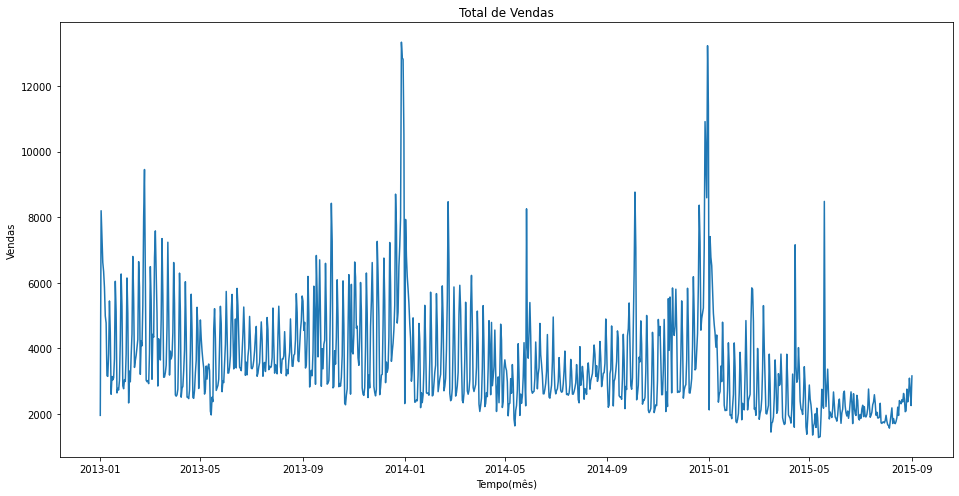

In [5]:
ts=sales.groupby(by=['date'])["item_cnt_day"].sum()
teste = ts.iloc[974:]
ts = ts.iloc[:-60]

ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total de Vendas')
plt.xlabel('Tempo(mês)')
plt.ylabel('Vendas')
plt.plot(ts);

Percebe a provável presença de sazonalidade na série, visto que temos picos semelhantemente espaçados em toda sua duração. Além disso, como as vendas parecem diminuir com o tempo, notamos também uma tendência decrescente.

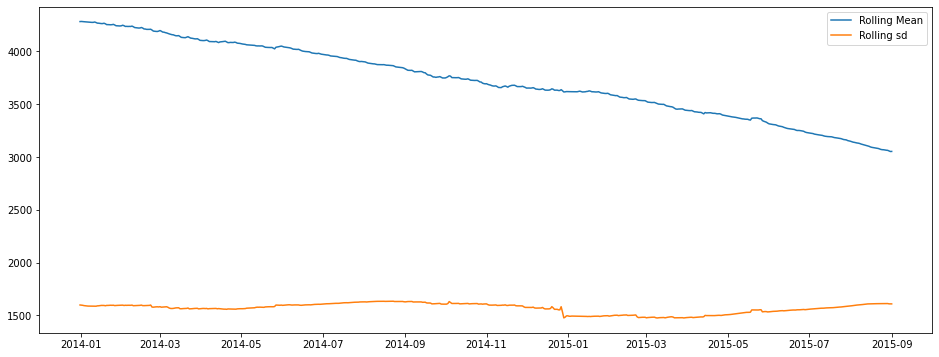

In [171]:
plt.figure(figsize=(16,6))
w=365
plt.plot(ts.rolling(window=w,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=w,center=False).std(),label='Rolling sd');
plt.legend();

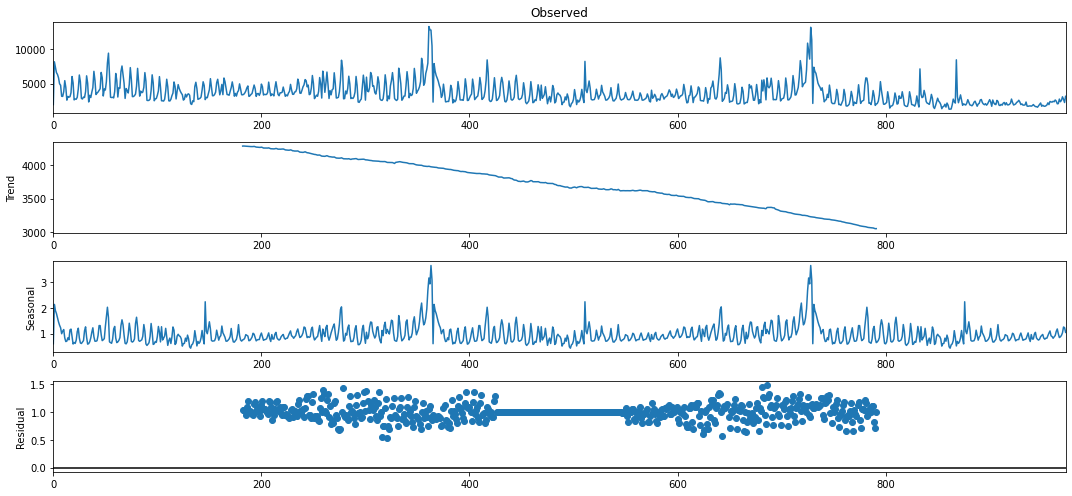

In [172]:

# multiplicative
resm = sm.tsa.seasonal_decompose(ts.values,period=365,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = resm.plot()
fig.show()

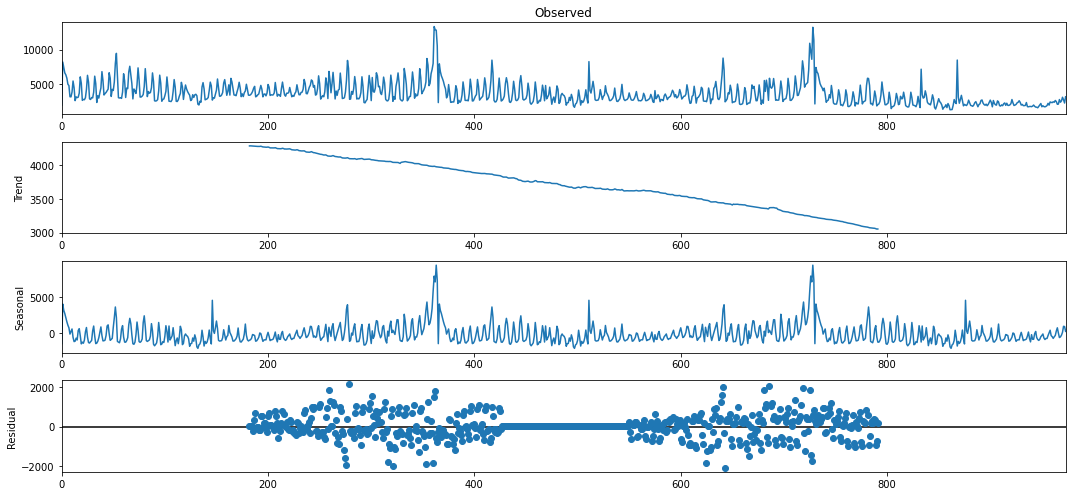

In [174]:
# Additive model
resa = sm.tsa.seasonal_decompose(ts.values,period=365,model="additive")
# plt.figure(figsize=(30,12))
resa.plot()
plt.show()

# salva resíduos
residuos = pd.DataFrame(resa.resid)
residuos = residuos.dropna()[0].to_numpy()

In [175]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(residuos)


Results of Dickey-Fuller Test:
Test Statistic                -5.679140e+00
p-value                        8.566394e-07
#Lags Used                     1.400000e+01
Number of Observations Used    5.950000e+02
Critical Value (1%)           -3.441388e+00
Critical Value (5%)           -2.866410e+00
Critical Value (10%)          -2.569363e+00
dtype: float64


[]

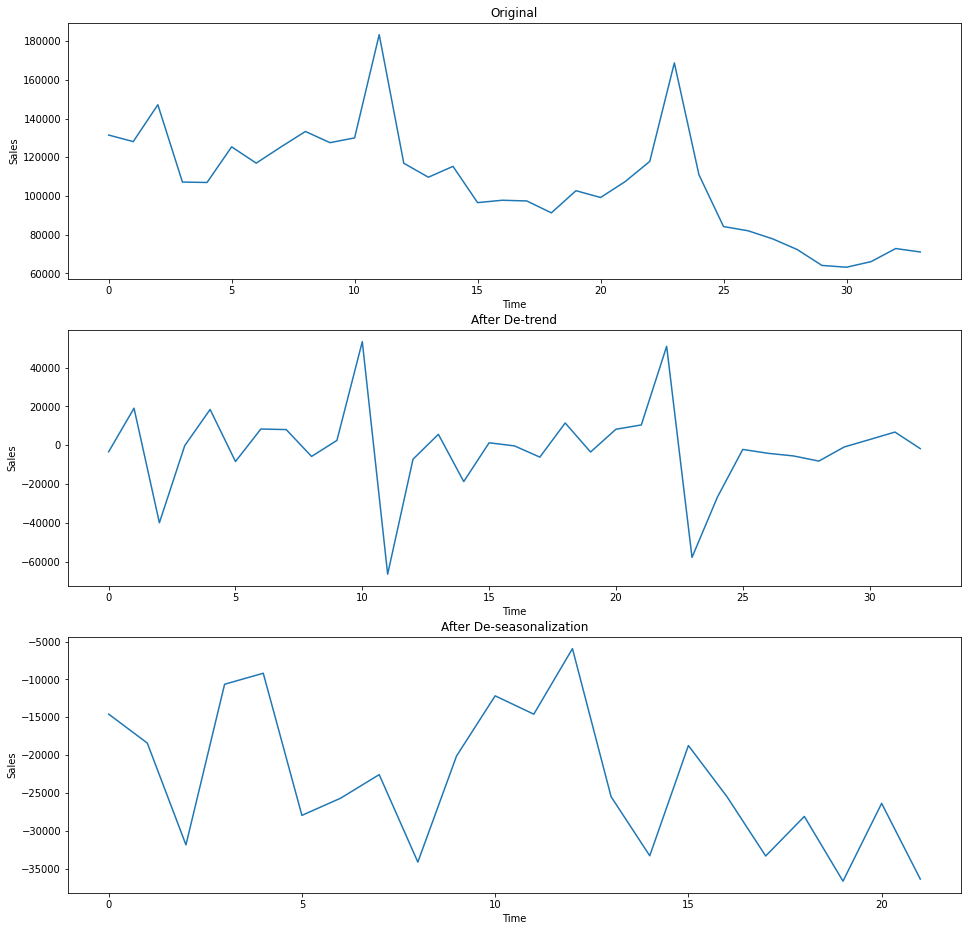

In [31]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

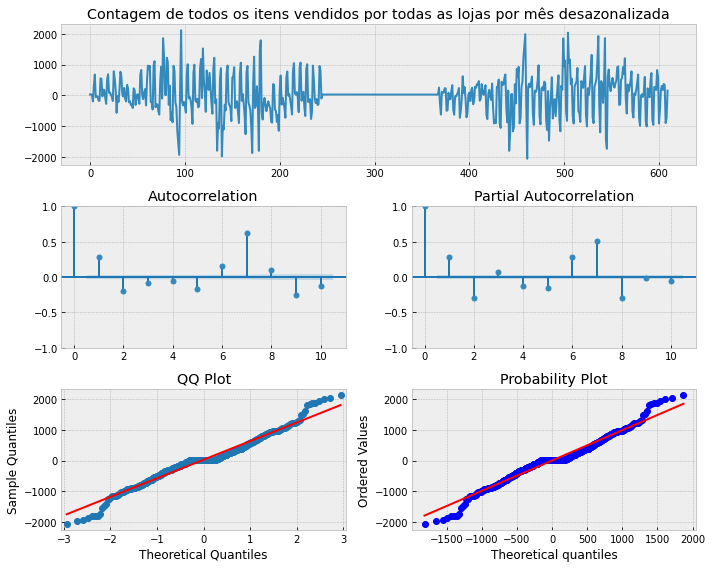

In [176]:
tsplot(residuos, lags=10,title="Contagem de todos os itens vendidos por todas as lojas por mês desazonalizada")

In [177]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(4)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = ARIMA(residuos, order=(i, 0, j)).fit()#ARIMA(arma22, order=(i, 0, j)).fit(method='mle', trend='nc')
            # print(tmp_mdl)
            tmp_aic = tmp_mdl.aic
            print(i,j,tmp_aic)
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


0 0 9545.638115726859
0 1 9457.616529079525
0 2 9446.130445990857
0 3 9440.77262622146
1 0 9498.3412645735
1 1 9450.498302864828
1 2 9444.201842392977
1 3 9437.595759880553
2 0 9445.910888455059
2 1 9443.240345389735
2 2 9444.352814644344
2 3 9317.680178780269
3 0 9444.873750531848
3 1 9445.237222872558
3 2 9446.153518182247
3 3 9378.681252922
aic: 9317.68018 | order: (2, 3)


In [178]:
model = ARIMA(residuos, order=(2, 0, 3)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  610
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -4651.840
Date:                Sat, 03 Dec 2022   AIC                           9317.680
Time:                        18:42:07   BIC                           9348.574
Sample:                             0   HQIC                          9329.698
                                - 610                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.2930     28.773      0.949      0.343     -29.101      83.687
ar.L1         -0.4476      0.006    -71.546      0.000      -0.460      -0.435
ar.L2         -0.9960      0.006   -163.239      0.0

In [146]:
## antigo
model = ARIMA(residuos, order=(2, 0, 3)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  670
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -5144.135
Date:                Sat, 03 Dec 2022   AIC                          10302.269
Time:                        18:23:24   BIC                          10333.820
Sample:                             0   HQIC                         10314.490
                                - 670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.9050     29.414      0.915      0.360     -30.745      84.555
ar.L1         -0.4501      0.002   -228.079      0.000      -0.454      -0.446
ar.L2         -0.9991      0.002   -550.287      0.0

### SARIMA